In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

We will go through an example of a classification task.

**Goals**:
- set up a binary classifer using scikit-learn
- classify cells from the rd10 dataset as either healthy (WT genotype) or diseased (rd10 homozygous genotype)
- evaluate the model's performance using a test dataset
- choose a penalty (options: None, "l1", "l2" or "elasticnet") and a suitable solver


Scikit-learn documentation:
- [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [2]:
pwd()

'/home/madan/code/data_analysis_course/session4'

# 1. Load dataset

We will use the same dataset from the previous tutorial
- Download dataset from the course google drive folder: `IOB (General) > PhD Program > Practical courses Spring 2024 > Data Analysis course June 2024 > session3 > practical > adata_course_filt.h5ad`


In [3]:
# TODO: Fill in the path to the anndata object
datadir = Path("../data")

adata = sc.read_h5ad(Path(datadir, "adata_course_filt.h5ad"))
adata

AnnData object with n_obs × n_vars = 14640 × 22429
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'fraction_mito', 'n_genes', 'num_spliced', 'num_ambiguous', 'num_unspliced', 'fraction_spliced', 'is_cell', 'is_high_quality', 'is_nonambient', 'is_not_debris', 'soupc_rho', 'n_counts', 'sample', 'age', 'genotype', 'dark_rearing', 'sample_group', 'cell_type'
    var: 'gene_ids', 'feature_types', 'soup_profile-323_MW-2021-10_MM_P35-Homo', 'soup_profile-324_MW-2021-10_MM_P35-Hetero', 'soup_profile-397_MW-2021-10_MM_P28-Hetero', 'soup_profile-397_MW-2021-10_MM_P28-Homo', 'soup_profile-411_MW-2021-10_MM_P35-Homo', 'soup_profile-412_MW-2021-10_MM_P35-Hetero', 'soup_profile-523_MW-2021-10_MM_P14-Hetero_1', 'soup_profile-524_MW-2021-10_MM_P14-Homo_1', 'soup_profile-538_MW-2021-19_MM_P21_HET', 'soup_profile-539_MW-2021-19_MM_P21_HOM', 'soup_profile-582_MW-2021-10_MM_P14_Homo_1', 'soup_profile-583_MW-2021-10_MM_P14_Hetero_1', 'soup_profile-618_MW-2021-10_MM_P28_Homo_1', 

Let's have a look at the labels that we are going to use in this tutorial:

In [4]:
adata.obs["genotype"].value_counts()

genotype
wt     7899
hom    6741
Name: count, dtype: int64

In [5]:
# TODO: Filter cells and genes using scanpy functions: `sc.pp.filter_cells` and `sc.pp.filter_genes`
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Remove multiplets, projecting_neurons and undefined cells
mask = adata.obs["cell_type"].str.contains("mult|undefined|neuron")
adata = adata[~mask].copy()

# Let's use highly_variable_genes to rank genes
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor="seurat_v3")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/madan/miniconda3/envs/s4_prac/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


# 2. Baseline model

**Task**: Use the pre-selected features (i.e., highly-variable genes) to train a classifier and report the accuracy of the predictions on the test set

Note that the number of genes is greater than the number of cells. Let's start by selecting the top 200 highly variable genes

In [6]:
adata_hv = adata[:, adata.var["highly_variable_rank"] < 200]
features = adata_hv.X
target = adata_hv.obs["genotype"]
features.shape, target.shape

((14344, 200), (14344,))

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Trick to get metadata associated with partitions
# df_train, df_test, y_train_, y_test_ = train_test_split(adata_hv.obs, target, test_size=0.3, random_state=42)

Let's check that the class labels are well-balance in both the training and test sets

In [8]:
y_train.value_counts()

genotype
wt     5483
hom    4557
Name: count, dtype: int64

In [9]:
y_test.value_counts()

genotype
wt     2325
hom    1979
Name: count, dtype: int64

In [10]:
# Define the logistic regression model
logreg = LogisticRegression(penalty=None, max_iter=1000)

# Train the logistic regression model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [11]:
print(f"Accuracy of logistic regression classifier on training set: {logreg.score(X_train, y_train):.4f}")
print(f"Accuracy of logistic regression classifier on test set: {logreg.score(X_test, y_test):.4f}")

Accuracy of logistic regression classifier on training set: 0.8215
Accuracy of logistic regression classifier on test set: 0.8183


In [12]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         hom       0.83      0.76      0.79      1979
          wt       0.81      0.87      0.84      2325

    accuracy                           0.82      4304
   macro avg       0.82      0.81      0.82      4304
weighted avg       0.82      0.82      0.82      4304



**Question**: Which of the two labels (`hom` or `wt`) can we predict more accurately?

# 3. Perform cross-validation to select regularization strength

Let's now use a larger set of genes. To achieve this, we suggest applying a penalty to constrain the weights/parameters of the model and avoid overfitting.
**Tip:**  Using all genes that pass QC steps would be ideal, but it can take too long to train the model. Therefore, consider a number of genes larger than 200 but fewer than 5000 (depending on your patience!).

We will use grid search to find a suitable regularization strength (`C` as implemented in scikit-learn). Grid search is a fundamental strategy for tuning hyperparameters. The process involves the following steps. For each hyperparameter, define a set of candidate values. Then, train separate models using every possible combination of these values. Finally, select the configuration that yields the lowest validation error.


**Tip:** Select a suitable solver depending on your choice of regularizer

In [13]:
# TODO: subset genes using highly_variable_genes rank
adata_hv = adata[:, adata.var.highly_variable]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(adata_hv.X, adata_hv.obs["genotype"], test_size=0.3, random_state=42)

Best regularization strength (C): 5
Accuracy of training set: 1.0000
Accuracy on test set: 0.9926

Classification Report:
              precision    recall  f1-score   support

         hom       0.99      0.99      0.99      1979
          wt       0.99      0.99      0.99      2325

    accuracy                           0.99      4304
   macro avg       0.99      0.99      0.99      4304
weighted avg       0.99      0.99      0.99      4304



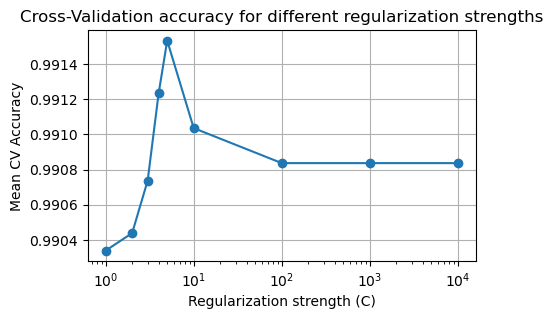

In [19]:
# TODO: Define the logistic regression model. Tips: choose `penalty`, `solver`, `max_iter`
logreg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=100, fit_intercept=False)

# TODO: Define the hyperparameter grid for regularization strength (C)
param_grid = {"C": [1, 2, 3, 4, 5, 10, 100, 1000, 10000]}

# Perform cross-validation to find the best regularization strength
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and the best regularization parameter
best_logreg = grid_search.best_estimator_
best_C = grid_search.best_params_["C"]

print(f"Best regularization strength (C): {best_C}")

# Train the logistic regression model with the best parameter on the entire training set
best_logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_logreg.predict(X_test)

# Evaluate the model
print(f"Accuracy of training set: {best_logreg.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {best_logreg.score(X_test, y_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

results = grid_search.cv_results_
plt.figure(figsize=(5, 3))
plt.plot(param_grid["C"], results["mean_test_score"], marker="o")
plt.xscale("log")
plt.xlabel("Regularization strength (C)")
plt.ylabel("Mean CV Accuracy")
plt.title("Cross-Validation accuracy for different regularization strengths")
plt.grid(True)
plt.show()

# Bonus: Neuron networks

Let's explore if using neural networks helps improving our classification task. Feel free to add as explore with the number of hidden layers and sizes, as well as the regularization strength (`alpha`)

In [20]:
from sklearn.neural_network import MLPClassifier

In [21]:
clf = MLPClassifier(solver="adam", alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9881505576208178